# Multitask GP Regression

In [8]:
import math
import torch
import gpytorch as gpt
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [9]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [10]:
train_x.shape, train_y.shape

(torch.Size([100]), torch.Size([100, 2]))

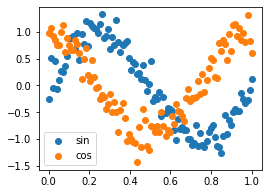

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x.numpy(), train_y.numpy()[:,0])
ax.scatter(train_x.numpy(), train_y.numpy()[:,1])
plt.legend(["sin", "cos"])

### Define a multitask model

In [14]:
class MultitaskGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.MultitaskMean(
            gpt.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpt.kernels.MultitaskKernel(
            gpt.kernels.RBFKernel(), num_tasks=2, rank=1
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpt.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train the model

In [16]:
training_iters = 50

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# Loss for the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iters, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.210
Iter 2/50 - Loss: 1.171
Iter 3/50 - Loss: 1.131
Iter 4/50 - Loss: 1.092
Iter 5/50 - Loss: 1.052
Iter 6/50 - Loss: 1.012
Iter 7/50 - Loss: 0.970
Iter 8/50 - Loss: 0.929
Iter 9/50 - Loss: 0.888
Iter 10/50 - Loss: 0.848
Iter 11/50 - Loss: 0.810
Iter 12/50 - Loss: 0.772
Iter 13/50 - Loss: 0.734
Iter 14/50 - Loss: 0.695
Iter 15/50 - Loss: 0.655
Iter 16/50 - Loss: 0.615
Iter 17/50 - Loss: 0.574
Iter 18/50 - Loss: 0.533
Iter 19/50 - Loss: 0.491
Iter 20/50 - Loss: 0.450
Iter 21/50 - Loss: 0.409
Iter 22/50 - Loss: 0.369
Iter 23/50 - Loss: 0.329
Iter 24/50 - Loss: 0.292
Iter 25/50 - Loss: 0.255
Iter 26/50 - Loss: 0.220
Iter 27/50 - Loss: 0.187
Iter 28/50 - Loss: 0.154
Iter 29/50 - Loss: 0.122
Iter 30/50 - Loss: 0.091
Iter 31/50 - Loss: 0.063
Iter 32/50 - Loss: 0.036
Iter 33/50 - Loss: 0.012
Iter 34/50 - Loss: -0.010
Iter 35/50 - Loss: -0.029
Iter 36/50 - Loss: -0.046
Iter 37/50 - Loss: -0.060
Iter 38/50 - Loss: -0.072
Iter 39/50 - Loss: -0.081
Iter 40/50 - Loss: -0.088
It

### Make predictions with the model

In [19]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpt.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

Text(0.5, 1.0, 'Observed Values (Likelihood)')

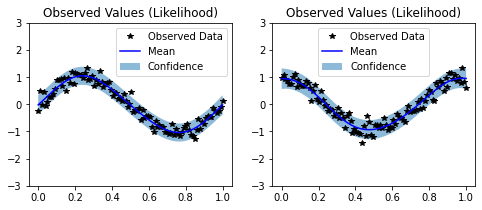

In [20]:
# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')